# Combine

Combine together the subsets as a single data layer (geojson?)

1. make a list of all the subsets (geojson)
2. read in the 1st subset
    a. add column for uid (granuleid, or name of the file)? What does the user need to find this
    Would the user know what collection this came from?
3. read next subset (loop over remaining)
    a. add column for uid (granuleid, or name of the file)? What does the user need to find this
    b. append to the 1st subset https://geopandas.org/en/stable/docs/user_guide/mergingdata.html
4. save final geodataframe as new geojson

In [15]:
import os
import os.path
from functools import reduce
from pathlib import Path
from typing import Iterable, Union
 
import geopandas as gpd
from profilehooks import timecall

import matplotlib.pyplot as plt

from gedi_utils import get_geo_boundary 

In [4]:
def chext(ext: str, path: str) -> str:
    return f'{os.path.splitext(path)[0]}{ext}'

In [5]:
def combine_subsets(paths: Iterable[Union[str, os.PathLike]]) -> gpd.GeoDataFrame:
    gdfs = (
        gpd.read_file(path).assign(filename=chext('.h5', os.path.basename(path)))
        for path in paths
    )
    
    return reduce(gpd.GeoDataFrame.append, gdfs, gpd.GeoDataFrame())

In [6]:
dirpath = Path('/') / 'projects' / 'my-public-bucket' / 'gedi-l4a' / 'gabon'

gabon_gdf = timecall(combine_subsets)(dirpath.glob('*.fgb'))
#gabon_gdf.to_file(dirpath.parent / 'gabon.fgb', driver='FlatGeobuf')
gabon_gdf


  combine_subsets (/tmp/ipykernel_3097/2207665546.py:1):
    19.166 seconds



,BEAM,agbd,agbd_se,l4_quality_flag,lat_lowestmode,lon_lowestmode,sensitivity,geometry,filename
0,BEAM1011,-9999.000000,-9999.000000,0,-1.641881,11.800564,1.663576,POINT (11.80056 -1.64188),GEDI04_A_2019108045816_O01962_01_T01066_02_002...
1,BEAM1011,-9999.000000,-9999.000000,0,-1.640194,11.801753,-0.006900,POINT (11.80175 -1.64019),GEDI04_A_2019108045816_O01962_01_T01066_02_002...
2,BEAM1011,-9999.000000,-9999.000000,0,-1.641037,11.801158,-11.257782,POINT (11.80116 -1.64104),GEDI04_A_2019108045816_O01962_01_T01066_02_002...
3,BEAM1011,-9999.000000,-9999.000000,0,-1.641459,11.800861,-3.026042,POINT (11.80086 -1.64146),GEDI04_A_2019108045816_O01962_01_T01066_02_002...
4,BEAM1011,-9999.000000,-9999.000000,0,-1.640616,11.801456,-3.575460,POINT (11.80146 -1.64062),GEDI04_A_2019108045816_O01962_01_T01066_02_002...
...,...,...,...,...,...,...,...,...,...
23270,BEAM1000,429.548584,17.125612,1,0.029887,12.528588,0.990790,POINT (12.52859 0.02989),GEDI04_A_2019115021551_O02069_02_T03606_02_002...
23271,BEAM1000,287.811005,17.121216,1,0.028623,12.527698,0.965249,POINT (12.52770 0.02862),GEDI04_A_2019115021551_O02069_02_T03606_02_002...
23272,BEAM1000,367.783478,17.125341,1,0.029044,12.527995,0.988107,POINT (12.52799 0.02904),GEDI04_A_2019115021551_O02069_02_T03606_02_002...
23273,BEAM1000,632.803894,17.139700,1,0.029465,12.528291,0.989402,POINT (12.52829 0.02947),GEDI04_A_2019115021551_O02069_02_T03606_02_002...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb11f9a810>]],
      dtype=object)

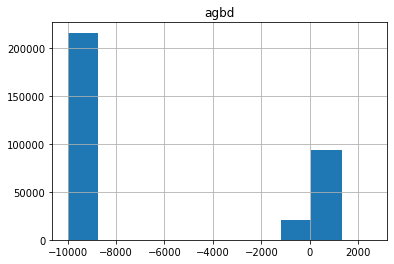

In [31]:
gabon_gdf.hist(column='agbd')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb1205cdd0>]],
      dtype=object)

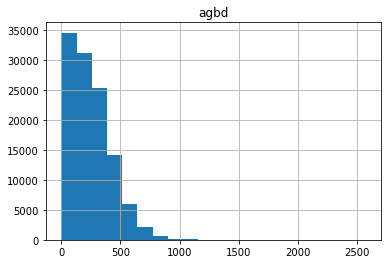

In [28]:
# histogram above shows a lot of nodata values -9999
# even without those the distribution is skewed, need different breaks or transformation
gabon_gdf[gabon_gdf['agbd'] > -9999].hist(column='agbd', bins=20)

In [29]:
# filter them out
gabon_valid_gdf = gabon_gdf[gabon_gdf['agbd'] > -9999]

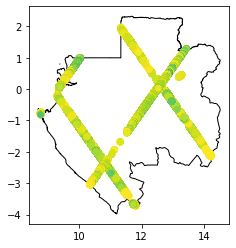

In [33]:
gabon_iso3 = get_geo_boundary('GAB', 0)
base = gabon_iso3.plot(color='white', edgecolor='black')
agbd_colors = plt.cm.get_cmap('viridis_r')
gabon_valid_gdf.plot(ax=base, column='agbd', cmap=agbd_colors);

In [ ]:
import folium

m = gabon_gdf.explore(
     cmap=agbd_colors, # use red color on all points
     marker_kwds=dict(radius=2, fill=True), # make marker radius 10px with fill
     tooltip="agbd", # show "name" column in the tooltip
     #tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
     name="agbd" # name of the layer in the map
)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

# too many points without aggregation
#m  # show map
